In [1]:
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
from sklearn.metrics import classification_report
import seaborn as sns

# Dataset

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
!unzip occupancy_data.zip

--2020-12-24 20:36:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335713 (328K) [application/x-httpd-php]
Saving to: ‘occupancy_data.zip’

occupancy_data.zip  100%[===================>] 327.84K  1.24MB/s    in 0.3s    

2020-12-24 20:36:03 (1.24 MB/s) - ‘occupancy_data.zip’ saved [335713/335713]

Archive:  occupancy_data.zip
  inflating: datatest.txt            
  inflating: datatest2.txt           
  inflating: datatraining.txt        


In [5]:
train = pd.read_table('datatraining.txt', delimiter=',')
test = pd.read_table('datatest.txt', delimiter=',')

In [6]:
print(f'Size = {len(train)}')
print('1 sum = ', sum(train['Occupancy'] == 1))
print('0 sum = ', sum(train['Occupancy'] == 0))
train.head()

Size = 8143
1 sum =  1729
0 sum =  6414


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [7]:
print(f'Size = {len(test)}')
print('1 sum = ', sum(test['Occupancy'] == 1))
print('0 sum = ', sum(test['Occupancy'] == 0))
test.head()

Size = 2665
1 sum =  972
0 sum =  1693


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


# Features

In [8]:
import calendar
features = train.iloc[:, 1:]
features['DayOfWeek'] = train['date'].apply(lambda x: calendar.weekday(int(x[:4]), int(x[5:7]), int(x[8 :10])))
features['hour'] = train['date'].apply(lambda x: int(x[11:13]))
features['minutes'] = train['date'].apply(lambda x: int(x[14:16]))
del features['Occupancy']
features['Occupancy'] = train['Occupancy']

In [9]:
features.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,DayOfWeek,hour,minutes,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,2,17,51,1
2,23.15,27.2675,429.5,714.00,0.004783,2,17,51,1
3,23.15,27.2450,426.0,713.50,0.004779,2,17,53,1
4,23.15,27.2000,426.0,708.25,0.004772,2,17,54,1
5,23.10,27.2000,426.0,704.50,0.004757,2,17,55,1


In [10]:
features.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,DayOfWeek,hour,minutes,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,3.344222,11.390642,29.494290,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,2.067996,7.092195,17.314343,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000,0.000000,0.000000,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,2.000000,5.000000,14.000000,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,4.000000,11.000000,29.000000,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,5.000000,18.000000,44.000000,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,6.000000,23.000000,59.000000,1.000000


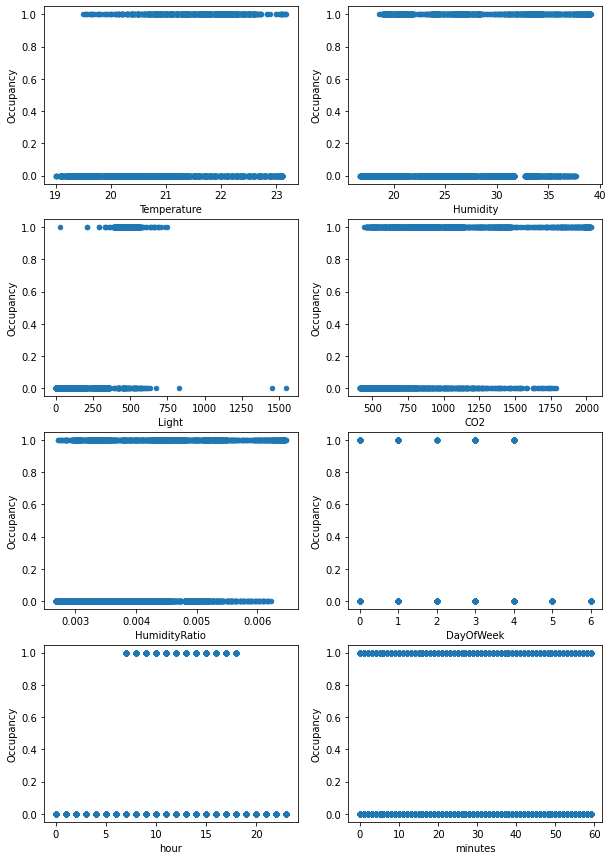

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
for idx, feature in enumerate(features.columns[:-1]):
    features.plot(feature, "Occupancy", subplots=True, kind="scatter", ax=axes[idx // 2, idx % 2])

In [12]:
features.iloc[:, :-1].corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,DayOfWeek,hour,minutes
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,-0.236655,0.260361,-0.003677
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,-0.456780,0.017134,-0.003542
Light,0.649942,0.037828,1.000000,0.664022,0.230420,-0.160210,0.084507,0.024375
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,-0.472879,0.209669,-0.002829
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,-0.537909,0.096271,-0.004677
DayOfWeek,-0.236655,-0.456780,-0.160210,-0.472879,-0.537909,1.000000,0.044140,0.002602
hour,0.260361,0.017134,0.084507,0.209669,0.096271,0.044140,1.000000,0.003630
minutes,-0.003677,-0.003542,0.024375,-0.002829,-0.004677,0.002602,0.003630,1.000000


In [13]:
features.corrwith(features['Occupancy'])

Temperature      0.538220
Humidity         0.132964
Light            0.907352
CO2              0.712235
HumidityRatio    0.300282
DayOfWeek       -0.251973
hour             0.079630
minutes          0.015929
Occupancy        1.000000
dtype: float64

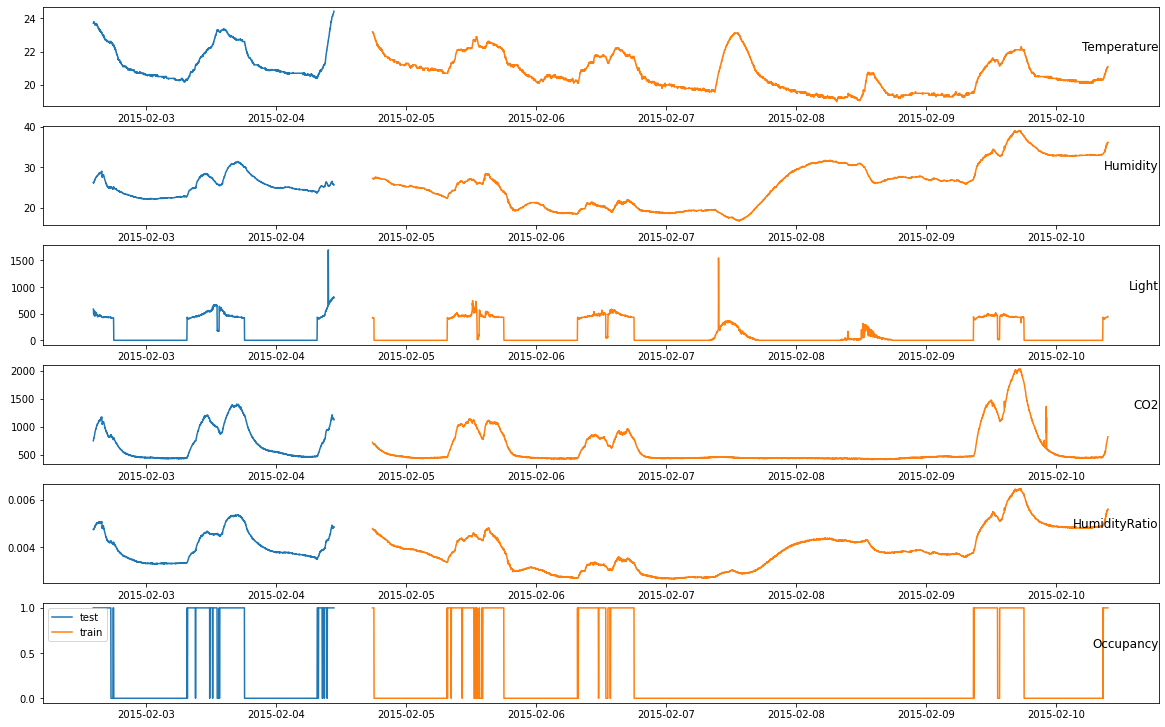

In [35]:

from pandas import read_csv
from matplotlib import pyplot

data1 = read_csv('datatest.txt', header=0, index_col=1, parse_dates=True, squeeze=True)
data2 = read_csv('datatraining.txt', header=0, index_col=1, parse_dates=True, squeeze=True)

n_features = data1.values.shape[1]
pyplot.figure(figsize = (20, 15))
for i in range(1, n_features):

	pyplot.subplot(n_features, 1, i)

	pyplot.plot(data1.index, data1.values[:, i], label = 'test')
	pyplot.plot(data2.index, data2.values[:, i], label = 'train')
  
	pyplot.title(data1.columns[i], y=0.5, loc='right')

pyplot.legend()  
pyplot.show()



# Scaling

In [36]:
train = pd.read_table('datatraining.txt', delimiter=',')
test = pd.read_table('datatest.txt', delimiter=',')

In [37]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['Temperature','Humidity','Light','CO2','HumidityRatio']
scaler = StandardScaler().fit(train[columns_to_scale].to_numpy())
train.loc[:,columns_to_scale] = scaler.transform(train[columns_to_scale].to_numpy())

In [38]:
scaler = StandardScaler().fit(test[columns_to_scale].to_numpy())
test.loc[:,columns_to_scale] = scaler.transform(test[columns_to_scale].to_numpy())

In [45]:
X, y = train.iloc[:, 1:-1].to_numpy(), train.iloc[:, -1].to_numpy()
X_TEST, y_TEST = test.iloc[:, 1:-1].to_numpy(), test.iloc[:, -1].to_numpy()

In [46]:
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,2.518470,0.278526,1.573763,0.364948,1.091757,1
2,2015-02-04 17:51:59,2.488967,0.277713,1.591735,0.341881,1.080555,1
3,2015-02-04 17:53:00,2.488967,0.273645,1.573763,0.340290,1.075888,1
4,2015-02-04 17:54:00,2.488967,0.265508,1.573763,0.323587,1.066555,1
5,2015-02-04 17:55:00,2.439796,0.265508,1.573763,0.311655,1.049523,1


In [47]:
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,2.204762,0.376814,1.566862,0.106940,1.207540,1
141,2015-02-02 14:19:59,2.222275,0.384202,1.539680,0.145214,1.221461,1
142,2015-02-02 14:21:00,2.233950,0.359575,1.516762,0.176881,1.209161,1
143,2015-02-02 14:22:00,2.226653,0.316478,1.201302,0.194253,1.174140,1
144,2015-02-02 14:23:00,2.257300,0.347262,1.180715,0.208776,1.211522,1


# Grid Search

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'penalty' : ['l1', 'l2']}
estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid)
optimizer.fit(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [49]:
best_params_lgr = optimizer.best_params_
print(best_params_lgr)

{'C': 1, 'penalty': 'l2'}


In [50]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [20, 50, 100, 150, 200], 'max_depth' : [5,10,20,30,50,70]}
estimator = RandomForestClassifier(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid)
optimizer.fit(X, y)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                          

In [51]:
best_params_rf = optimizer.best_params_
print(best_params_rf)

{'max_depth': 5, 'n_estimators': 50}


# Baseline

In [54]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def train_(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)
  return  precision_score(y_pred, y_test), recall_score(y_pred, y_test), f1_score(y_pred, y_test), roc_auc_score( y_test, y_proba[:,1])

def test_(clf, X_test, y_test):
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)
  print(classification_report(y_test, y_pred, digits = 4))
  return precision_score(y_pred, y_test), recall_score(y_pred, y_test), f1_score(y_pred, y_test), roc_auc_score( y_test, y_proba[:,1]) 


## Logistic Regression

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
f1_scores = []
prec_scores = []
recall_scores = []
roc_auc_scores = []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  prec, rec, f1, ru = train_(LogisticRegression(C = 1, penalty = 'l2' ), X_train, y_train, X_test, y_test)
  prec_scores.append(prec)
  recall_scores.append(rec)
  f1_scores.append(f1)
  roc_auc_scores.append(ru)

print('TRAIN:')
print(f'Precision = {np.mean(prec_scores)}')
print(f'Recall = {np.mean(recall_scores)}')
print(f'F1 = {np.mean(f1_scores)}')
print(f'ROC_AUC = {np.mean(roc_auc_scores)}')

clf_lr = LogisticRegression(C = 1, penalty = 'l2')
clf_lr.fit(X,y)
print(f"TEST:")
test_prec, test_recall, test_f1, test_ru = test_(clf_lr, X_TEST, y_TEST)



TRAIN:
Precision = 0.9872832369942197
Recall = 0.9553089409223764
F1 = 0.9710196261156714
ROC_AUC = 0.9950514543000093
TEST:
              precision    recall  f1-score   support

           0     0.8609    0.9870    0.9196      1693
           1     0.9696    0.7222    0.8278       972

    accuracy                         0.8904      2665
   macro avg     0.9153    0.8546    0.8737      2665
weighted avg     0.9005    0.8904    0.8862      2665



In [57]:
for name_feature, weight in zip(train.columns[1:6], clf_lr.coef_[0]):
    
    print(f'название признака: {name_feature} - вес:  {weight}')

название признака: Temperature - вес:  -1.2531112359576764
название признака: Humidity - вес:  0.1924565547460842
название признака: Light - вес:  3.913228119263064
название признака: CO2 - вес:  1.8958514457036362
название признака: HumidityRatio - вес:  -0.3946819866532173


## Random Forest

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
f1_scores = []
prec_scores = []
recall_scores = []
roc_auc_scores = []
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  prec, rec, f1, ru = train_(RandomForestClassifier(n_estimators = 100, max_depth = 100 ), X_train, y_train, X_test, y_test)
  prec_scores.append(prec)
  recall_scores.append(rec)
  f1_scores.append(f1)
  roc_auc_scores.append(ru)

print('TRAIN:')
print(f'Precision = {np.mean(prec_scores)}')
print(f'Recall = {np.mean(recall_scores)}')
print(f'F1 = {np.mean(f1_scores)}')
print(f'ROC_AUC = {np.mean(roc_auc_scores)}')

clf = RandomForestClassifier(n_estimators = 50, max_depth = 30 )
clf.fit(X,y)
print(f"TEST:")
test_prec, test_recall, test_f1, test_ru = test_(clf, X_TEST, y_TEST)


TRAIN:
Precision = 0.9861271676300577
Recall = 0.9865350369152532
F1 = 0.986321380306036
ROC_AUC = 0.9990089689511654
TEST:
              precision    recall  f1-score   support

           0     0.9543    0.9740    0.9640      1693
           1     0.9530    0.9187    0.9356       972

    accuracy                         0.9538      2665
   macro avg     0.9537    0.9464    0.9498      2665
weighted avg     0.9538    0.9538    0.9537      2665

